In [3]:
import json
import glob
import itertools

from pathlib import Path
import numpy as np
import pandas as pd

from qiskit import transpile, QuantumCircuit
from qiskit.providers.fake_provider import FakeLima
from qiskit.primitives import Estimator, BackendEstimator
from qiskit.circuit.random import random_circuit
from qiskit.quantum_info import SparsePauliOp

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import dropout

from torch_geometric.nn import (
    GCNConv, 
    TransformerConv, 
    GATv2Conv, 
    global_mean_pool, 
    Linear, 
    ChebConv, 
    SAGEConv,
    ASAPooling,
    dense_diff_pool,
    avg_pool_neighbor_x
)
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, to_dense_batch

from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns

from blackwater.data.loaders.exp_val import CircuitGraphExpValMitigationDataset
from blackwater.data.generators.exp_val import exp_value_generator
from blackwater.data.utils import generate_random_pauli_sum_op
from blackwater.library.ngem.estimator import ngem
from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)
from blackwater.data.generators.exp_val import ExpValueEntry
from blackwater.metrics.improvement_factor import improvement_factor, Trial, Problem

from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_aer.noise import NoiseModel
import qiskit_aer.noise as noise

from qiskit.providers.models import BackendProperties

from pprint import pprint
import copy

In [2]:
backend = FakeLima()
properties = get_backend_properties_v1(backend)

In [3]:
# 0. generate data
# 1. create orinal noise model (nm0)
# 2. train model on nm0 with 10k circuits and get MSE
# 3. wiggle noise model (nm1) and check MSE 
# 4. train model from scratch with 1k, 2k, 3k, 4k, ... and get MSE
# 5. plot

### Generate data

In [ ]:
# # circuits data

# N_FILES = 100
# N_ENTRIES_PER_FILE = 100

# for i in tqdm_notebook(range(N_FILES)):
#     with open(f"./data/stability_over_time_experiment/circuits/qasm_circuits_{i}.txt", "w") as f:
#         for _ in range(N_ENTRIES_PER_FILE):
#             circuit = transpile(
#                 random_circuit(5, 1, measure=True), 
#                 basis_gates=backend.configuration().basis_gates,
#                 optimization_level=0
#             )
            
#             f.write(circuit.qasm())
#             f.write("=====\n")

In [21]:
# build estimator

In [4]:
import requests

In [5]:
lima_props = json.loads(
    requests.get(
        "https://raw.githubusercontent.com/Qiskit/qiskit-terra/3241978340f534b76e4cf0e5e25ed16e2af5cf78/qiskit/providers/fake_provider/backends/lima/props_lima.json"
    ).text
)

In [11]:
backend_original = FakeLima()
backend_tweaked = FakeLima()

In [12]:
backend_original.properties = lambda: BackendProperties.from_dict(lima_props)

In [29]:
aer_estimator = AerEstimator()
estimator_original = BackendEstimator(backend_original, skip_transpilation=True)

In [7]:
def change_properties(lima_props, lower_bound: float = 1.0, upper_bound: float = 3.0):
    """Changes qubit and gate properties by given bounds.
    
    Returns:
        New qubit and gate properties
    """
    CHANGE = np.random.uniform(lower_bound, upper_bound)
    
    new_qubits = []
    for qubit in lima_props["qubits"]:
        new_qubit = []
        for param in qubit:
            new_param = param.copy()
            new_param["value"] = param["value"] * CHANGE
            new_qubit.append(new_param)

        new_qubits.append(new_qubit)

    new_gates = []
    for gate in lima_props["gates"]:
        new_gate = gate.copy()

        new_parameters = []
        for param in gate["parameters"]:
            new_param = param.copy()
            new_param["value"] = param["value"] * CHANGE
            new_parameters.append(new_param)

        new_gate["parameters"] = new_parameters

        new_gates.append(new_gate)
        
    return new_qubits, new_gates

change_properties(lima_props)

KeyboardInterrupt: 

In [9]:
lima_props['gates']

[{'qubits': [0],
  'gate': 'id',
  'parameters': [{'date': '2021-03-15T00:11:29-04:00',
    'name': 'gate_error',
    'unit': '',
    'value': 0.00019195510390342677},
   {'date': '2021-03-15T00:36:03-04:00',
    'name': 'gate_length',
    'unit': 'ns',
    'value': 35.55555555555556}],
  'name': 'id0'},
 {'qubits': [1],
  'gate': 'id',
  'parameters': [{'date': '2021-03-15T00:13:23-04:00',
    'name': 'gate_error',
    'unit': '',
    'value': 0.00033064681663890665},
   {'date': '2021-03-15T00:36:03-04:00',
    'name': 'gate_length',
    'unit': 'ns',
    'value': 35.55555555555556}],
  'name': 'id1'},
 {'qubits': [2],
  'gate': 'id',
  'parameters': [{'date': '2021-03-15T00:11:29-04:00',
    'name': 'gate_error',
    'unit': '',
    'value': 0.0001807726361160903},
   {'date': '2021-03-15T00:36:03-04:00',
    'name': 'gate_length',
    'unit': 'ns',
    'value': 35.55555555555556}],
  'name': 'id2'},
 {'qubits': [3],
  'gate': 'id',
  'parameters': [{'date': '2021-03-15T00:11:29-04:

In [24]:
tweaked_lima_props = lima_props.copy()

new_qubits, new_gates =  change_properties(lima_props, 1.0, 3.0)

tweaked_lima_props["gates"] = new_gates
tweaked_lima_props["qubits"] = new_qubits

In [45]:
shifts_range = range(1, 11, 3)

obs = SparsePauliOp(["ZZZZZ"])

tweaked_estimators = []
tweaked_backends = []

for shift in shifts_range:
    tweaked_lima_props = lima_props.copy()

    new_qubits, new_gates =  change_properties(lima_props, shift, shift + 2)

    tweaked_lima_props["gates"] = new_gates
    tweaked_lima_props["qubits"] = new_qubits
    
    backend_tweaked.properties = lambda: BackendProperties.from_dict(tweaked_lima_props)
    
    estimator_tweaked = BackendEstimator(backend_tweaked, skip_transpilation=True)
    
    tweaked_estimators.append(estimator_tweaked)
    tweaked_backends.append(backend_tweaked)

In [34]:
N_FILES = 20

for i in tqdm_notebook(range(N_FILES)):
    with open(f"./data/stability_over_time_experiment/circuits/qasm_circuits_{i}.txt", "r") as f:
        qasm_strings = f.read().split("=====")[:-1]

        with open(f"./data/stability_over_time_experiment/measurements/results_{i}.txt", "w") as fr:
            for qasm in qasm_strings:
                circuit = QuantumCircuit.from_qasm_str(qasm)

                estimators = [aer_estimator, estimator_original] + tweaked_estimators
                
                ideal_exp_vals = create_meas_data_from_estimators(
                    circuits=circuit, 
                    observables=obs, 
                    estimators=estimators,
                    shots=10000
                )

                fr.write(",".join([str(x) for x in ideal_exp_vals]))
                fr.write("\n")

  0%|          | 0/20 [00:00<?, ?it/s]

In [39]:
n_shifts = len(list(shifts_range))

In [48]:
observable = encode_pauli_sum_op(SparsePauliOp("ZZZZZ"))

for i in tqdm_notebook(range(N_FILES)):
    circuits = []
    with open(f"./data/stability_over_time_experiment/circuits/qasm_circuits_{i}.txt", "r") as fc:
        qasm_strings = fc.read().split("=====")[:-1]
        circuits = [QuantumCircuit.from_qasm_str(qasm)
                    for qasm in qasm_strings]

    measurements = []
                                       
    df = pd.read_csv(f"./data/stability_over_time_experiment/measurements/results_{i}.txt", header=None)
    df.columns = ["ideal", "noise"] + [f"shift_{x}" for x in range(n_shifts)]

    for row in df.iterrows():
        measurements.append([
            row[1]["ideal"],
            row[1]["noise"]
        ] + [
            row[1][f"shift_{x}"] for x in range(n_shifts)
        ])    
                       
    original_entries = []
    tweaked_entries = {
        x: [] for x in range(n_shifts)
    }

    for mments, circuit in zip(measurements, circuits):
        ideal_ev, original_ev, tweaked_meas = mments[0], mments[1], mments[2:]
         
        original_graph_data = circuit_to_graph_data_json(
            circuit=circuit,
            properties=get_backend_properties_v1(backend_original),
            use_qubit_features=True,
            use_gate_features=True,
        )
        original_entry = ExpValueEntry(
            circuit_graph=original_graph_data,
            observable=observable,
            ideal_exp_value=ideal_ev,
            noisy_exp_values=[original_ev],
            circuit_depth=circuit.depth()
        ) 
        
        original_entries.append(original_entry.to_dict())
        
        for idx, (tweaked_ev, tweaked_bcknd) in enumerate(zip(tweaked_meas, tweaked_backends)):
            tweaked_graph_data = circuit_to_graph_data_json(
                circuit=circuit,
                properties=get_backend_properties_v1(tweaked_bcknd),
                use_qubit_features=True,
                use_gate_features=True,
            )

            tweaked_entry = ExpValueEntry(
                circuit_graph=tweaked_graph_data,
                observable=observable,
                ideal_exp_value=ideal_ev,
                noisy_exp_values=[tweaked_ev],
                circuit_depth=circuit.depth()
            )
            
            tweaked_entries[idx].append(tweaked_entry.to_dict())
             
    save_file_path = f"./data/stability_over_time_experiment/pyg_data/original/{i}.json"
    with open(save_file_path, "w") as json_file:
        json.dump(original_entries, json_file)
             
    for idx, entries in tweaked_entries.items():
        folder = f"./data/stability_over_time_experiment/pyg_data/tweaked_{idx}"
        Path(folder).mkdir(parents=True, exist_ok=True)
        save_file_path = f"{folder}/{i}.json"
        
        with open(save_file_path, "w") as json_file:
            json.dump(entries, json_file)

  0%|          | 0/20 [00:00<?, ?it/s]

###  Train networks

In [187]:
max_files_to_use = 20
train_size = 15

data_paths = glob.glob("./data/stability_over_time_experiment/pyg_data/original/**.json")[:max_files_to_use]

BATCH_SIZE = 10

train_loader = DataLoader(
    CircuitGraphExpValMitigationDataset(
        data_paths[:train_size],
    ),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    CircuitGraphExpValMitigationDataset(
        data_paths[train_size:],
    ),
    batch_size=BATCH_SIZE,
    shuffle=False
)

for data in train_loader:
    print(data)
    break

DataBatch(x=[286, 22], edge_index=[2, 585], edge_attr=[299, 3], y=[10, 1], observable=[10, 1, 21], circuit_depth=[10, 1], noisy_0=[10, 1], batch=[286], ptr=[11])


In [188]:
class ExpValCircuitGraphModel(torch.nn.Module):
    def __init__(
        self,
        n_qubits: int,
        num_node_features: int,
        hidden_channels: int
    ):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, 1)
        
        self.cheb_conv1 = ChebConv(num_node_features, hidden_channels, K=3)
        self.cheb_conv2 = ChebConv(hidden_channels, 1, K=2)

        self.sage_conv1 = SAGEConv(num_node_features, hidden_channels)
        self.sage_conv2 = SAGEConv(hidden_channels, 1)
        
        self.obs_seq = torch.nn.Sequential(
            Linear(n_qubits * 4 + 1, hidden_channels),
            torch.nn.Dropout(0.2),
            Linear(hidden_channels, 1)
        )
        
        self.body_seq = torch.nn.Sequential(
            Linear(6, hidden_channels),
            Linear(hidden_channels, 1)
        )

    def forward(self, 
                exp_value, observable, 
                circuit_depth, nodes, 
                edge_index, batch):
        # GCN
        graph = self.conv1(nodes, edge_index).relu()
        graph = dropout(graph, training=self.training, p=0.1)
        graph = self.conv2(graph, edge_index).relu()
        graph = dropout(graph, training=self.training, p=0.1)
        graph = self.conv3(graph, edge_index)
        graph = global_mean_pool(graph, batch)
        
        # Cheb
        cheb = self.cheb_conv1(nodes, edge_index).relu()
        cheb = dropout(cheb, training=self.training, p=0.2)
        cheb = self.cheb_conv2(cheb, edge_index)
        cheb = global_mean_pool(cheb, batch)
        
        # Sage
        sage = self.sage_conv1(nodes, edge_index).relu()
        sage = dropout(sage, training=self.training, p=0.2)
        sage = self.sage_conv2(sage, edge_index)
        sage = global_mean_pool(sage, batch)
        
        obs = self.obs_seq(observable)
        obs = torch.mean(obs, dim=1)
        
        merge = torch.cat((
            graph, 
            cheb,
            sage,
            obs,
            circuit_depth,
            exp_value
        ), dim=1)

        return self.body_seq(merge)

In [190]:
GLOBAL_LR = 0.0001
N_EPOCHS = 10

In [229]:
model = ExpValCircuitGraphModel(
    n_qubits=5,
    num_node_features=22, 
    hidden_channels=10
)
optimizer = Adam(model.parameters(), lr=GLOBAL_LR)
criterion = torch.nn.MSELoss()
scheduler = ReduceLROnPlateau(optimizer, 
                              'min', 
                              factor=0.5, 
                              patience=20, 
                              verbose=True, 
                              min_lr=0.000001)

In [230]:
min_valid_loss = np.inf

train_losses = []
val_losses = []

progress = tqdm_notebook(range(N_EPOCHS*2), desc='Model training', leave=True)
for epoch in progress:
    train_loss = 0.0
    model.train()
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()

        out = model(
            data.noisy_0, 
            data.observable, 
            data.circuit_depth,
            data.x, 
            data.edge_index, 
            data.batch
        )
        loss = criterion(out, data.y)        
        
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
                
    valid_loss = 0.0
    model.eval()
    for i, data in enumerate(val_loader):
        out = model(data.noisy_0, data.observable, data.circuit_depth, data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)        

        valid_loss += loss.item()

    scheduler.step(valid_loss)

    if epoch >= 1:    
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(valid_loss / len(val_loader))

        progress.set_description(f"{round(train_losses[-1], 5)}, {round(val_losses[-1], 5)}")
        progress.refresh()

Model training:   0%|          | 0/20 [00:00<?, ?it/s]

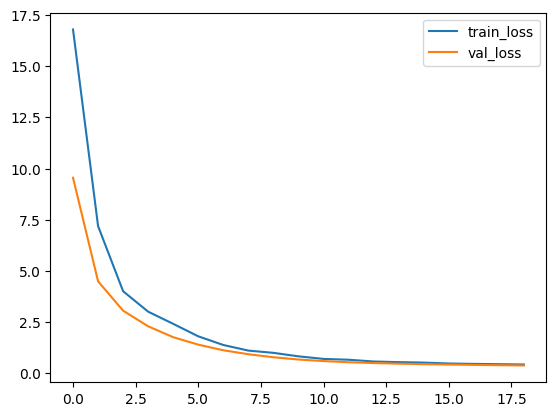

In [231]:
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
# plt.yscale('log')

plt.legend()
plt.show()

In [194]:
final_error = val_losses[-1]
final_error

0.5287716485733209

In [195]:
# plt.plot(val_losses)
# plt.show()

In [196]:
def post_train_model(model, train_loader, val_loader):
    optimizer = Adam(model.parameters(), lr=GLOBAL_LR)
    criterion = torch.nn.MSELoss()
    scheduler = ReduceLROnPlateau(optimizer, 
                                  'min', 
                                  factor=0.5, 
                                  patience=20, 
                                  verbose=True, 
                                  min_lr=0.000001)
    
    min_valid_loss = np.inf

    train_losses = []
    val_losses = []

    progress = tqdm_notebook(range(N_EPOCHS), desc='Model training', leave=True)
    for epoch in progress:
        train_loss = 0.0
        model.train()
        for i, data in enumerate(train_loader):
            optimizer.zero_grad()

            out = model(
                data.noisy_0, 
                data.observable, 
                data.circuit_depth,
                data.x, 
                data.edge_index, 
                data.batch
            )
            loss = criterion(out, data.y)        

            train_loss += loss.item()

            loss.backward()
            optimizer.step()

        valid_loss = 0.0
        model.eval()
        for i, data in enumerate(val_loader):
            out = model(data.noisy_0, data.observable, data.circuit_depth, data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)        

            valid_loss += loss.item()

        scheduler.step(valid_loss)

        if epoch >= 1:    
            train_losses.append(train_loss / len(train_loader))
            val_losses.append(valid_loss / len(val_loader))

            progress.set_description(f"{round(train_losses[-1], 5)}, {round(val_losses[-1], 5)}")
            progress.refresh()
    
    return val_losses

In [197]:
tweaked_losses = []

for idx in tqdm_notebook(range(n_shifts)):
    tweaked_data_paths = glob.glob(f"./data/stability_over_time_experiment/pyg_data/tweaked_{idx}/**.json")[:max_files_to_use]
    
    tweaked_train_loader = DataLoader(
        CircuitGraphExpValMitigationDataset(
            tweaked_data_paths[:train_size],
        ),
        batch_size=BATCH_SIZE,
        shuffle=True
    )

    tweaked_val_loader = DataLoader(
        CircuitGraphExpValMitigationDataset(
            tweaked_data_paths[train_size:],
        ),
        batch_size=BATCH_SIZE,
        shuffle=False
    )
    
    model_copy = copy.deepcopy(model)

    res = post_train_model(model_copy, tweaked_train_loader, tweaked_val_loader)
    
    tweaked_losses.append(res)

  0%|          | 0/4 [00:00<?, ?it/s]

Model training:   0%|          | 0/10 [00:00<?, ?it/s]

Model training:   0%|          | 0/10 [00:00<?, ?it/s]

Model training:   0%|          | 0/10 [00:00<?, ?it/s]

Model training:   0%|          | 0/10 [00:00<?, ?it/s]

In [198]:
model_from_scratch = ExpValCircuitGraphModel(
    n_qubits=5,
    num_node_features=22, 
    hidden_channels=10
)
optimizer = Adam(model_from_scratch.parameters(), lr=GLOBAL_LR)
criterion = torch.nn.MSELoss()
scheduler = ReduceLROnPlateau(optimizer, 
                              'min', 
                              factor=0.5, 
                              patience=20, 
                              verbose=True, 
                              min_lr=0.000001)

min_valid_loss = np.inf

train_losses = []
val_losses = []

progress = tqdm_notebook(range(N_EPOCHS), desc='Model training', leave=True)
for epoch in progress:
    train_loss = 0.0
    model_from_scratch.train()
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()

        out = model_from_scratch(
            data.noisy_0, 
            data.observable, 
            data.circuit_depth,
            data.x, 
            data.edge_index, 
            data.batch
        )
        loss = criterion(out, data.y)        
        
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
                
    valid_loss = 0.0
    model_from_scratch.eval()
    for i, data in enumerate(val_loader):
        out = model_from_scratch(data.noisy_0, data.observable, data.circuit_depth, data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)        

        valid_loss += loss.item()

    scheduler.step(valid_loss)

    if epoch >= 1:    
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(valid_loss / len(val_loader))
        
        if tweaked_losses[-1][-1] > val_losses[-1]:
            break

        progress.set_description(f"{round(train_losses[-1], 5)}, {round(val_losses[-1], 5)}")
        progress.refresh()

[9.450379936085191,
 4.392636608522992,
 2.9582744728687196,
 2.1951593038647674,
 1.6635156352852665,
 1.299276543495267,
 1.025503741378008,
 0.8324147053236185,
 0.6842359814879506,
 0.573568127980066,
 0.49732134345658996,
 0.441268450229667,
 0.4012047807144564,
 0.370573227072871,
 0.3477846480386202,
 0.32782895509586774,
 0.3111303766799528,
 0.2966482018315515,
 0.282635310292244]

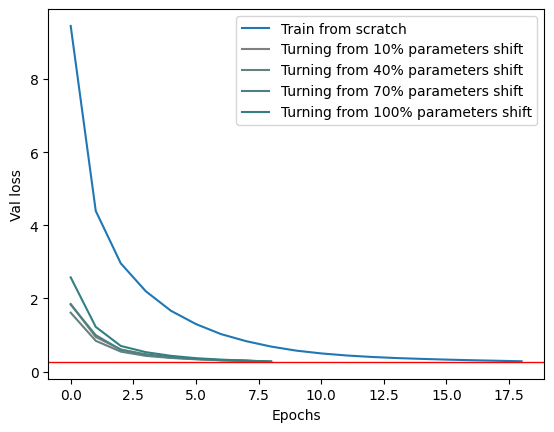

In [300]:
plt.plot(val_losses, label="Train from scratch")

for idx, tweaked_loss in enumerate(tweaked_losses):
    plt.plot(tweaked_loss, label=f"Turning from {shifts_range[idx]*10}% parameters shift", color=(0.5 - 0.1*idx, 0.5, 0.5))

plt.axhline(y=tweaked_losses[0][-1], color='r', linestyle='-', lw=1)

plt.xlabel("Epochs")
plt.ylabel("Val loss")
plt.legend()
# plt.yscale("log")
plt.show()

In [306]:
with open("./results/stability_results.json", "w") as f:
    json.dump({
        "from_scratch": val_losses,
        "tuned": tweaked_losses
    }, f)